In [1]:
#@title === DRIVE MOUNT ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title === INSTALLATIONS ===
!pip install torch_geometric -q
!apt-get install -y graphviz libgraphviz-dev pkg-config -q
!pip install pygraphviz -q

Reading package lists...
Building dependency tree...
Reading state information...
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
#@title === IMPORTS ===
import os
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm, to_hex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import networkx.algorithms.community as nxac
import matplotlib.lines as mlines


/tmp/ipython-input-3943978899.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  icefire_cmap = cm.get_cmap("RdYlGn_r", len(custom_ranges))


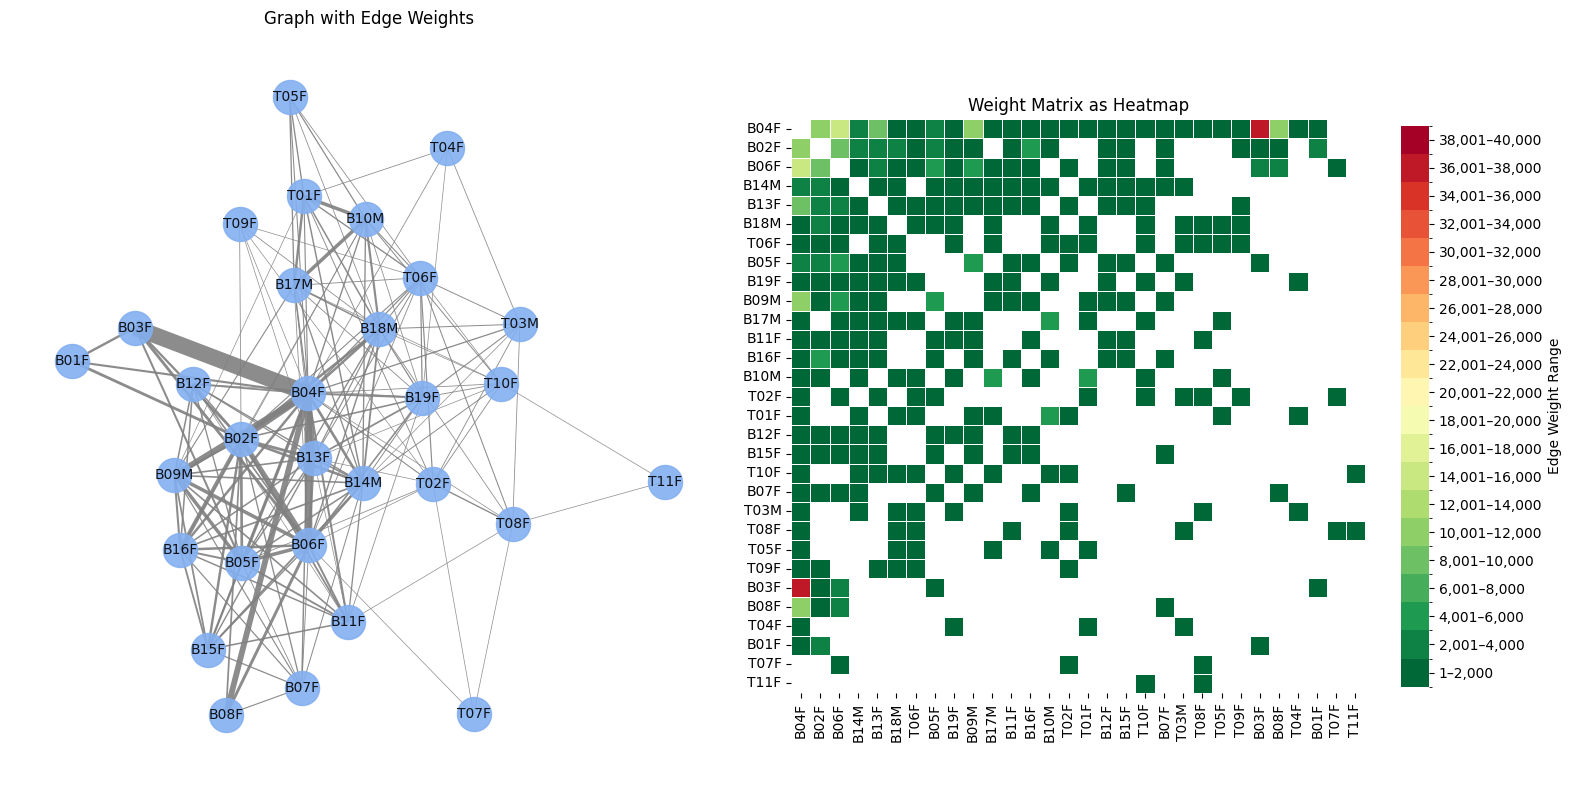

In [ ]:
#@title === LOAD GRAPH ===
graph_path = os.path.join("/content/drive/Othercomputers/My Laptop/Node clustering/Association rules", "Graph.gml")
G = nx.read_gml(graph_path)

# === GRAPH WEIGHTS ===
weights = [G[u][v]['weight'] for u, v in G.edges()]
safe_weights = [max(w, 1) for w in weights]
log_weights = np.log10(weights)+2
# Convert to NumPy array before reshaping
safe_weights_array = np.array(safe_weights).reshape(-1, 1)
normalized_weights = MinMaxScaler().fit_transform(safe_weights_array).flatten()

weights_vis= np.array(log_weights) / 4 + normalized_weights*10

# === CUSTOM RANGES ===
min_w, max_w = min(weights), max(weights)
step = 2000
custom_ranges = [(i, i + step - 1) for i in range(int(min_w), int(max_w + step), step)]


# === GET icefire REVERSED COLORMAP AND SAMPLE 21 COLORS ===
icefire_cmap = cm.get_cmap("RdYlGn_r", len(custom_ranges))
colors = [to_hex(icefire_cmap(i)) for i in range(len(custom_ranges))]
cmap = ListedColormap(colors)
bin_edges = [low for low, _ in custom_ranges] + [custom_ranges[-1][1] + 1]
norm = BoundaryNorm(bin_edges, cmap.N)

# === BUILD ADJACENCY MATRIX ===
nodes = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)
adj_matrix = pd.DataFrame(index=nodes, columns=nodes)

for u in nodes:
    for v in nodes:
        adj_matrix.loc[u, v] = G[u][v]['weight'] if G.has_edge(u, v) else np.nan

adj_matrix = adj_matrix.astype(float)

# === PLOT GRAPH AND HEATMAP ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Plot 1: Graph ---
pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
nx.draw(G, pos=pos, node_size=600, node_color='#83aff0', font_size=10,  with_labels=True, width=weights_vis, edge_color='gray', alpha=0.9, ax=ax1)
ax1.set_title("Graph with Edge Weights")

# --- Plot 2: Discrete Heatmap with Custom Ranges ---
sns.heatmap(adj_matrix, cmap=cmap, norm=norm, square=True, linewidths=0.5,
            cbar_kws={"label": "Edge Weight Range", "shrink": 0.75},
            annot=False, ax=ax2)

# Set custom ticks based on bin centers
tick_pos = [(low + high) / 2 for (low, high) in custom_ranges]
tick_labels = [f"{low:,}–{high:,}" for (low, high) in custom_ranges]


colorbar = ax2.collections[0].colorbar
colorbar.set_ticks(tick_pos)
colorbar.set_ticklabels(tick_labels)
colorbar.set_label("Edge Weight Range")
ax2.set_title("Weight Matrix as Heatmap")

plt.tight_layout()
plt.show()


In [ ]:
min_weight = min(weights)
max_weight = max(weights)
print(f"Minimum weight: {min_weight}")
print(f"Maximum weight: {max_weight}")

Minimum weight: 1
Maximum weight: 37282


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

    torch.backends.cudnn.benchmark = False

In [ ]:
#@title === NODE & EDGE DATA PROCESSING ===

def get_node_data(G):
    #----------------------------- Node Features -----------------------------------------
    node_list = list(G.nodes())

    # --- Node Attribute Mappings ---
    specie_mapping = {s: i for i, s in enumerate(set(nx.get_node_attributes(G, "Specie").values()))}
    sex_mapping = {s: i for i, s in enumerate(set(nx.get_node_attributes(G, "Sex").values()))}

    # --- Normalize Length ---
    length_values = np.array(list(nx.get_node_attributes(G, "Length_cm").values())).reshape(-1, 1)
    length_scaler = MinMaxScaler()
    scaled_lengths = length_scaler.fit_transform(length_values)
    length_mapping = dict(zip(nx.get_node_attributes(G, "Length_cm").keys(), scaled_lengths.flatten()))

    # --- Build Node Feature Matrix ---
    node_features = []
    for node in node_list:
        specie = specie_mapping[G.nodes[node]["Specie"]]
        sex = sex_mapping[G.nodes[node]["Sex"]]
        length = length_mapping[node]
        node_features.append([specie, sex, length])
    node_features = np.array(node_features)
    node_features = StandardScaler().fit_transform(node_features)

    # --- Node Indexing ---
    node_mapping = {node: i for i, node in enumerate(node_list)}

    # --- Association Rules Node Features ---
    node_features_df = pd.read_csv("/content/drive/Othercomputers/My Laptop/Node clustering/Association rules/node_feature_matrix.csv", index_col=0)
    node_features_df = node_features_df.loc[node_list]  # Align with node_list
    node_features_df = np.array(node_features_df)
    node_features_df = MinMaxScaler().fit_transform(node_features_df)

    # ---- c
    combined_features = np.hstack((node_features, node_features_df))

    # --- Normalize Node Features ---
    x = torch.tensor(combined_features, dtype=torch.float)


    #----------------------------- Edge Features -----------------------------------------

    # --- Edge Construction ---
    edge_index = []
    edge_weights = []
    edge_binary_features = []
    edge_durations = []

    binary_keys = [
        "Grand_Harbor", "Citrons_Bay_Wide_Beach", "Small_Harbor", "Vata_Bay_Wide_Beach",
        "Islets", "Saint_Marie_Bay", "Saint_Marie_Bay_Nautical_Center",
        "Magenta_Bay", "Dumbea_Bay", "Citrons_Bay_Beachfront", "Vata_Bay_Beachfront"
    ]

    for u, v in G.edges():
        edge_data = G[u][v]
        edge_index.append([node_mapping[u], node_mapping[v]])
        edge_weights.append([edge_data.get("weight", 0)])
        edge_durations.append([
            edge_data.get("min_duration_m", 0.0),
            edge_data.get("max_duration_m", 0.0)
        ])
        edge_binary_features.append([edge_data.get(k, 0) for k in binary_keys])

    # Normalize numeric edge features
    edge_weights = MinMaxScaler().fit_transform(edge_weights)
    edge_durations = MinMaxScaler().fit_transform(edge_durations)

    # Combine edge features
    edge_attr_array = np.hstack((edge_weights, edge_durations, edge_binary_features))
    edge_attr = torch.tensor(edge_attr_array, dtype=torch.float)

    # Build edge index tensor
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
#@title === PLOT FUNCTION ===

def plot_graph_and_pca(G, embeddings, partition, weights_vis, pos=pos, title_prefix=""):
    unique_clusters = sorted(set(partition.values()))
    colormap = plt.colormaps.get_cmap("tab10")
    cluster_colors = {label: colormap(i % colormap.N) for i, label in enumerate(unique_clusters)}
    node_colors = [cluster_colors[partition[node]] for node in G.nodes()]

    fig, ax = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1]})

    # Graph drawing
    nx.draw(G, pos=pos, node_color=node_colors, node_size=600, font_size=10,
            with_labels=True, width=weights_vis, edge_color='gray', alpha=0.7, ax=ax[0])
    ax[0].set_title(f"{title_prefix}Graph Clustering")
    handles = [mlines.Line2D([0], [0], marker='o', color='w', label=f'Cluster {label}',
               markersize=10, markerfacecolor=cluster_colors[label]) for label in unique_clusters]
    ax[0].legend(handles=handles, title="Clusters")

    # t-SNE projection
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    tsne_embeddings = tsne.fit_transform(embeddings)

    for label in unique_clusters:
        idx = [i for i, node in enumerate(G.nodes()) if partition[node] == label]
        ax[1].scatter(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1],
                      color=cluster_colors[label], label=f'Cluster {label}', s=50)

    for j, node_id in enumerate(G.nodes()):
        x, y = tsne_embeddings[j]
        ax[1].text(x + 0.01, y + 0.01, str(node_id), fontsize=7)

    ax[1].set_title(f"{title_prefix}t-SNE of Clustering")
    ax[1].set_xlabel("t-SNE1")
    ax[1].set_ylabel("t-SNE2")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()
    return fig

In [ ]:
#@title === GCN MODEL ===

class GCN_EdgePredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super(GCN_EdgePredictor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

        # Edge decoder
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * out_channels, hidden_channels),
            nn.ReLU()
        )

        # Heads: 3 regression targets, 11 binary classifications
        self.regression_head = nn.Linear(hidden_channels, 3)  # weight, min, max
        self.binary_head = nn.Linear(hidden_channels, 11)    # 11 area binary flags

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GCN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        # Edge-level features from node pairs
        src, dst = edge_index[0], edge_index[1]
        edge_feat = torch.cat([x[src], x[dst]], dim=1)
        h = self.edge_mlp(edge_feat)

        # Split outputs
        pred_reg = self.regression_head(h)               # shape [num_edges, 3]
        pred_bin = torch.sigmoid(self.binary_head(h))    # shape [num_edges, 11]

        return x, pred_reg, pred_bin


In [ ]:
#@title === GAT MODEL ===
from torch_geometric.nn import GATConv

class GAT_EdgePredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1, heads=4):
        super(GAT_EdgePredictor, self).__init__()
        self.dropout = dropout
        self.heads = heads

        # First GAT layer
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)

        # Second GAT layer
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=True, dropout=dropout)

        # Edge decoder
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * out_channels, hidden_channels),
            nn.ReLU()
        )

        # Output heads
        self.regression_head = nn.Linear(hidden_channels, 3)   # 3 regression outputs
        self.binary_head = nn.Linear(hidden_channels, 11)      # 11 binary classification outputs

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GAT layers with attention
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)

        # Construct edge-level features
        src, dst = edge_index[0], edge_index[1]
        edge_feat = torch.cat([x[src], x[dst]], dim=1)
        h = self.edge_mlp(edge_feat)

        # Output predictions
        pred_reg = self.regression_head(h)               # shape: [num_edges, 3]
        pred_bin = torch.sigmoid(self.binary_head(h))    # shape: [num_edges, 11]

        return x, pred_reg, pred_bin

In [ ]:
#@title === TRAIN FUNCTION ==

def train(model, data, epochs=60, lr=0.01, G=None, alpha=1.0, title_prefix_model=""):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_values, silhouette_scores = [], []

    best_slt, best_partition, best_embeddings, best_epoch = -1, None, None, 0

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        _, pred_reg, pred_bin = model(data)

        # === Ground truth split ===
        true_reg = data.edge_attr[:, :3]     # weight, min_duration, max_duration
        true_bin = data.edge_attr[:, 3:]     # Area1–11

        # === Loss ===
        loss_reg = F.mse_loss(pred_reg, true_reg)
        loss_bin = F.binary_cross_entropy(pred_bin, true_bin)
        loss = loss_reg + alpha * loss_bin

        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())

        # === Clustering / Evaluation ===
        model.eval()
        node_embeddings = model(data)[0].detach().cpu().numpy()
        embeddings_df = pd.DataFrame(node_embeddings, index=list(G.nodes()))


        # Clustering
        ap_model = AffinityPropagation(random_state=42).fit(embeddings_df)
        clusters = ap_model.labels_
        partition = {node: cluster for node, cluster in zip(G.nodes(), clusters)}
        exemplar_indices = ap_model.cluster_centers_indices_
        exemplar_names = embeddings_df.index[exemplar_indices]

        # Silhouette
        slt = silhouette_score(embeddings_df, clusters, metric='cosine')
        silhouette_scores.append(slt)

        print('#' * 100)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Silhouette Score: {slt:.4f}")
        print('#' * 100)

        # Early stopping
        if slt >= best_slt:
            best_slt, best_partition, best_embeddings, best_epoch, best_ap_model = slt, partition, embeddings_df, epoch, ap_model


        # Print clusters
        cluster_to_nodes = defaultdict(list)
        for node, cluster in partition.items():
            cluster_to_nodes[cluster].append(node)
        print("\n📌 Cluster Exemplars:")
        for cluster_id, exemplar in enumerate(exemplar_names):
            members = cluster_to_nodes[cluster_id]
            members_str = ', '.join(sorted(str(m) for m in members))
            print(f"Cluster {cluster_id} (Exemplar: {exemplar}) : {members_str}")



        fig_epoch = plot_graph_and_pca(G, embeddings_df, partition, weights_vis, pos, title_prefix=f"Epoch = {epoch} Partition visualisation ")
        fig_epoch.savefig(f"/content/drive/Othercomputers/My Laptop/Node clustering/Association rules/results/{title_prefix_model}/epoch_{epoch}_partition_visualisation_plots.png", bbox_inches='tight', dpi=300)
        fig_epoch.clear()
        plt.close(fig_epoch)


    # === Final Report ===
    best_exemplar_indices = best_ap_model.cluster_centers_indices_
    best_exemplar_names = best_embeddings.index[best_exemplar_indices]
    print(f"\n✅ Best clustering at epoch {best_epoch} with Silhouette Score = {best_slt:.4f}, Loss = {loss_values[best_epoch - 1]:.4f}\n")
    cluster_to_nodes = defaultdict(list)
    for node, cluster in best_partition.items():
            cluster_to_nodes[cluster].append(node)
    print("\n📌 Cluster Exemplars:")
    for cluster_id, exemplar in enumerate(best_exemplar_names):
        members = cluster_to_nodes[cluster_id]
        members_str = ', '.join(sorted(str(m) for m in members))
        print(f"Cluster {cluster_id} (Exemplar: {exemplar}) : {members_str}")

    # === Visualization ===
    fig = plot_graph_and_pca(G, best_embeddings, best_partition, weights_vis, pos, title_prefix=f"{title_prefix_model} Best partition visualisation ")
    fig.savefig(f"/content/drive/Othercomputers/My Laptop/Node clustering/Association rules/results/{title_prefix_model}_best_partition_visualisation_plots.png", bbox_inches='tight', dpi=300)
    plt.close(fig)

    # === Metric Plot ===
    plt.figure(figsize=(12, 8))
    plt.annotate( f'Best clustering at epoch {best_epoch}\nSilhouette Score = {best_slt:.4f},\nLoss = {loss_values[best_epoch - 1]:.4f}',
                  xy=(best_epoch, best_slt),            # Point to the best score on the curve
                  xytext=(125 , 0.7),                    # Top-left corner for annotation text (x in epochs, y in score space)
                  textcoords='data',
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
                  bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray"),
                  fontsize=10,
              )

    plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', color='orange')
    plt.plot(range(1, len(silhouette_scores) + 1), silhouette_scores, label='Silhouette', color='green')
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Metric Value", fontsize=14)
    plt.title(f"{title_prefix_model} Training Progress", fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"/content/drive/Othercomputers/My Laptop/Node clustering/Association rules/results/{title_prefix_model}_training_progress.png")
    plt.show()
    plt.close()
    return best_slt, best_partition, best_embeddings, best_epoch, loss_values

In [ ]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)
data = get_node_data(G)
input_dim, hidden_dim, output_dim = data.x.shape[1], 200, 100

In [ ]:
#@title === SETUP & TRAIN ===
set_seed(42)
model = GCN_EdgePredictor(input_dim, hidden_dim, output_dim)
best_slt_GCN, best_partition_GCN, best_embeddings_GCN, best_epoch_GCN, loss_values_GCN = train(model, data, epochs=200, lr=0.001, G=G, title_prefix_model="GCN_200")

In [ ]:
#@title === SETUP & TRAIN ===
set_seed(42)
model = GAT_EdgePredictor(input_dim, hidden_dim, output_dim)
best_slt_GAT, best_partition_GAT, best_embeddings_GAT, best_epoch_GAT, loss_values_GAT = train(model, data, epochs=200, lr=0.001, G=G, title_prefix_model="GAT4_200")

=== Clustering Agreement Metrics ===
 - Rand Index: 0.825


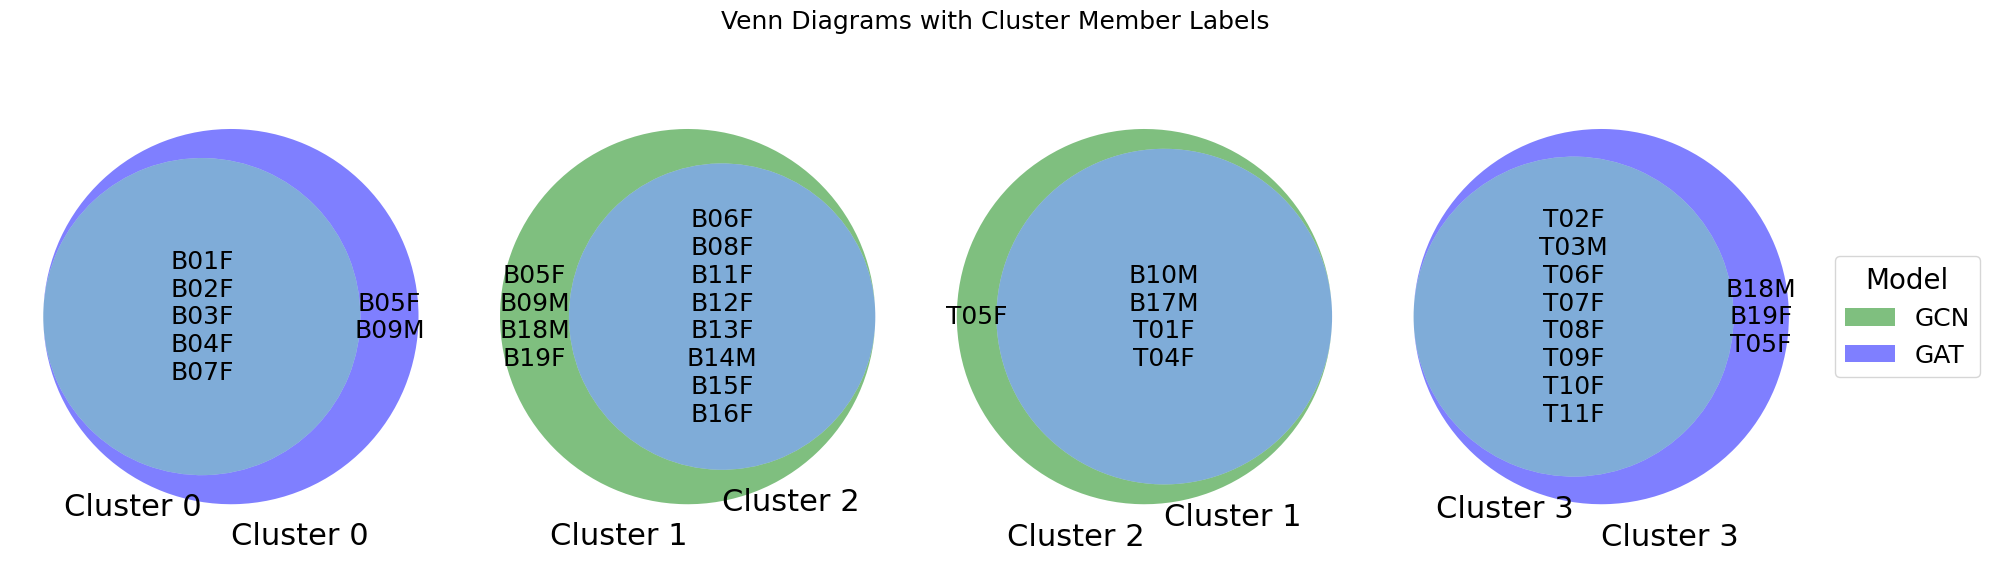

In [34]:
#@title === Clusters Comparison ===

from sklearn.metrics import rand_score
from matplotlib_venn import venn2
import matplotlib.pyplot as plt


def create_labels(clusters, elements):
    """Create label vector from cluster dictionaries."""
    labels = []
    for e in elements:
        assigned = -1
        for clust_id, members in clusters.items():
            if e in members:
                assigned = clust_id
                break
        labels.append(assigned)
    return labels




def plot_venn_with_labels(GCN_clusters, GAT_clusters, save_path=None):
    """Venn diagrams showing member IDs inside each region."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    for i in range(4):
        if i == 1:
            set1 = GCN_clusters[i]
            set2 = GAT_clusters[i + 1]
            venn = venn2([set1, set2], set_labels=(f'Cluster {i}', f'Cluster {i+1}'), ax=axes[i], set_colors=('green', 'blue'), alpha=0.5)
        elif i == 2:
            set1 = GCN_clusters[i]
            set2 = GAT_clusters[i - 1]
            venn = venn2([set1, set2], set_labels=(f'Cluster {i}', f'Cluster {i-1}'), ax=axes[i], set_colors=('green', 'blue'), alpha=0.5)
        else:
            set1 = GCN_clusters[i]
            set2 = GAT_clusters[i]
            venn = venn2([set1, set2], set_labels=(f'Cluster {i}', f'Cluster {i}'), ax=axes[i], set_colors=('green', 'blue'), alpha=0.5)
        for text in venn.set_labels:
            if text:
                text.set_fontsize(22)

        regions = {
            '10': set1 - set2,
            '01': set2 - set1,
            '11': set1 & set2,
        }

        for region_code, elements in regions.items():
            label = venn.get_label_by_id(region_code)
            if label:
                label.set_text("\n".join(sorted(elements)) if elements else '')
                label.set_fontsize(18)

    fig.suptitle('Venn Diagrams with Cluster Member Labels', fontsize=18)
    plt.legend(['GCN', 'GAT'], loc='center left', bbox_to_anchor=(1, 0.5), title='Model', title_fontsize=20, fontsize=18)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()


def print_agreement_metrics(name1, labels1, name2, labels2):
    """Print clustering agreement metrics."""
    print(f" - Rand Index: {rand_score(labels1, labels2):.3f}")


# === Define Clusters ===
GCN_clusters = defaultdict(set)

for node, cluster_id in best_partition_GCN.items():
    GCN_clusters[cluster_id].add(node)

# Convert to regular dict
GCN_clusters = dict(GCN_clusters)

GAT_clusters = defaultdict(set)

for node, cluster_id in best_partition_GAT.items():
    GAT_clusters[cluster_id].add(node)

# Convert to regular dict
GAT_clusters = dict(GAT_clusters)

# === Agreement Metrics ===
all_elements = sorted(set().union(*GCN_clusters.values(), *GAT_clusters.values()))
labels_tec1 = create_labels(GCN_clusters, all_elements)
labels_tec2 = create_labels(GAT_clusters, all_elements)

print("=== Clustering Agreement Metrics ===")
print_agreement_metrics("GCN", labels_tec1, "GAT", labels_tec2)

# === Venn Diagram with Member Labels ===
plot_venn_with_labels(
    GCN_clusters, GAT_clusters,
    save_path="/content/drive/Othercomputers/My Laptop/Node clustering/Association rules/results/venn_with_labels.png"
)
